# Random Forest

**랜덤포레스트** : 기계 학습에서의 랜덤 포레스트(random forest)는 분류, 회귀 분석 등에 사용되는 앙상블 학습 방법의 일종으로, 훈련 과정에서 구성한 다수의 결정 트리로부터 분류 또는 평균 예측치(회귀 분석)를 출력함으로써 동작한다.

- 앙상블 알고리즘 중 수행속도가 빠르다
- 다양한 영역에서 높은 예측성능을 보인다
- 기반 알고리즘 : 결정트리

**사용 하이퍼 파라미터**
- n_estimators: 트리 수, 클수록 성능은 좋아질 수 있지만 시간이 오래 걸림
- max_depth: 트리의 최대 깊이, 과적합 개선하기 위해 사용
- min_samples_leaf: 리프 노드에 있어야 하는 최소 샘플 수
- min_samples_split: 내부 노드를 분할하는 데 필요한 최소 샘플 수
- n_jobs: -1로 설정시 컴퓨팅 프로세서 최대한 활용
- random_state: 임의의 정수로 설정 시 실행할 때마다 결과가 바뀌지 않고 고정됨

### 모델링 과정과 결과
- Standard Scaler, MinMax Scaler, Robust Scaler, Log Scaler 4가지 스케일러를 각각 적용한 데이터와 스케일링 하지 않은 데이터로 나누어 Random Forest 모델링 진행
- 결론적으로 스케일링을 수행하지 않은 데이터가 가장 최적 모델로 선정됨

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # for modeling
from sklearn.preprocessing import LabelEncoder # for encoding
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler #for standardization
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix

시력 데이터가 연속형 데이터이므로 범주화하여 전처리 진행
- 시력 데이터 범주화
    - 0.1~0.9: 나쁨(1)
    - 1.0~1.5: 보통(2)
    - 1.6~2.0: 좋음(3)
    - 9.9: 실명(4)


In [2]:
def preprocessing(df_scaling, scaled_form = 'MinMaxScaler()'):
    # 불필요한 컬럼 제거
    if 'ID' in df_scaling:
        df_scaling = df_scaling.drop("ID", axis = 1)
        if len(df_scaling.columns) == 1:
            return df_scaling
        # 시력(eyesight) 데이터 범주화
        # 시력 기준
        # (0.1~0.9): 나쁨(1)
        # (1.0~1.5): 보통(2)
        # (1.6~2.0): 좋음(3)
        # (9.9): 실명(4)

        def func(x):
            if x < 1.0 :
                return 1
            elif x < 1.6 :
                return 2
            elif x <= 2.0 :
                return 3
            else : 
                return 4
        df_scaling['eyesight(left)'] = df_scaling['eyesight(left)'].apply(lambda x:func(x))    
        df_scaling['eyesight(right)'] = df_scaling['eyesight(right)'].apply(lambda x:func(x))
        
        
        df_scaling = df_scaling.drop('oral', axis = 1) 
        # 범주형 피처 레이블 인코딩 
        cate_features = df_scaling[['gender','tartar']]

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["gender"])
        df_scaling["gender"] = lbe.fit_transform(df_scaling["gender"])

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["tartar"])
        df_scaling["tartar"] = lbe.fit_transform(df_scaling["tartar"])
        # hearing 피처 1, 2 => 1, 0으로 변환
        df_scaling['hearing(left)'] = df_scaling['hearing(left)'].apply(lambda x: x-2 if x ==2.0 else x )
        df_scaling['hearing(right)'] = df_scaling['hearing(right)'].apply(lambda x: x-2 if x ==2.0 else x )
        
        # Urine protein 범주화
        x = df_scaling['Urine protein']
        for i in range(len(x)):
            if(x[i] == 1.0):
                x[i] = 0
            elif(x[i] == 2.0):
                x[i] = 1
            else:
                x[i] = 2
        df_scaling['Urine protein'] = x


        # BMI 지수 계산
        # bmi = kg/m^2
        df_scaling['bmi'] = df_scaling['weight(kg)']/((df_scaling['height(cm)']*0.01)**2)
        # wwi(비만 지수) 지수 계산
        df_scaling['wwi'] = df_scaling['waist(cm)']/(df_scaling['weight(kg)'].apply(np.sqrt))
        return df_scaling

In [3]:
def scaling(train_data, test_data, scaled_form = 'MinMaxScaler()'):
    # 형태 별 특성 구분
    train_data = preprocessing(train_data)
    test_data = preprocessing(test_data)
    tr_cate_features = train_data[['gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries','eyesight(left)','eyesight(right)']]
    tr_scaled_features = train_data.drop(tr_cate_features.columns, axis=1)
    ts_cate_features = test_data[['gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries','eyesight(left)','eyesight(right)']]
    ts_scaled_features = test_data.drop(ts_cate_features.columns, axis=1)
    
    if scaled_form == 'StandardScaler()':
        # Standard scaler
        scaler = StandardScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        train_std_scaled = pd.DataFrame(tr_scaled, columns=tr_scaled_features.columns)
        train_std_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_std_scaled = pd.DataFrame(ts_scaled, columns=ts_scaled_features.columns)
        test_std_scaled[ts_cate_features.columns] = ts_cate_features
        
        return train_std_scaled, test_std_scaled
    
    elif scaled_form == 'RobustScaler()':
        # Robust scaler
        scaler = RobustScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        # 데이터 프레임 형태로 변환
        train_robust_scaled = pd.DataFrame(tr_scaled, columns=tr_scaled_features.columns)
        train_robust_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_robust_scaled = pd.DataFrame(ts_scaled, columns=ts_scaled_features.columns)
        test_robust_scaled[ts_cate_features.columns] = ts_cate_features
        
        return train_robust_scaled, test_robust_scaled
    
    elif scaled_form == 'logScaler' :
        tr_scaled = np.log1p(tr_scaled_features)
        ts_scaled = np.log1p(ts_scaled_features)
         # 데이터 프레임 형태로 변환
        train_log_scaled = pd.DataFrame(tr_scaled, columns = tr_scaled_features.columns)
        train_log_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_log_scaled = pd.DataFrame(ts_scaled,columns = ts_scaled_features.columns)
        test_log_scaled[ts_cate_features.columns] = ts_cate_features 
        
        return train_log_scaled, test_log_scaled
        
    else:
        # MinMax scaler
        scaler = MinMaxScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        # 데이터 프레임 형태로 변환
        train_mmx_scaled = pd.DataFrame(tr_scaled, columns = tr_scaled_features.columns)
        train_mmx_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_mmx_scaled = pd.DataFrame(ts_scaled,columns = ts_scaled_features.columns)
        test_mmx_scaled[ts_cate_features.columns] = ts_cate_features

        return train_mmx_scaled, test_mmx_scaled

In [4]:
# 파일 로드
x_train = pd.read_csv('./Smoking_raw/competition_format/x_train.csv')
x_test = pd.read_csv('./Smoking_raw/competition_format/x_test.csv')
y_train = pd.read_csv('./Smoking_raw/competition_format/y_train.csv')
y_test = pd.read_csv('./Smoking_raw/competition_format/y_test.csv')

In [ ]:
x_train_org = preprocessing(x_train) # 스케일링 진행하지 않은 원본 데이터로 전처리 진행
x_test_org = preprocessing(x_test)
y_train_org = preprocessing(y_train)
y_test_org = preprocessing(y_test)

C:\Users\Yeon\AppData\Local\Temp\ipykernel_15456\3416163575.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 0
C:\Users\Yeon\AppData\Local\Temp\ipykernel_15456\3416163575.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 2
C:\Users\Yeon\AppData\Local\Temp\ipykernel_15456\3416163575.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i] = 1


In [11]:
x_train_org.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,bmi,wwi
0,0,40,155,60,81.3,2,2,1.0,1.0,114.0,...,12.9,0.0,0.7,18.0,19.0,27.0,0.0,1,24.973985,10.495785
1,0,40,160,60,81.0,1,1,1.0,1.0,119.0,...,12.7,0.0,0.6,22.0,19.0,18.0,0.0,1,23.437500,10.457055
2,1,55,170,60,80.0,1,1,1.0,1.0,138.0,...,15.8,0.0,1.0,21.0,16.0,22.0,0.0,0,20.761246,10.327956
3,1,40,165,70,88.0,2,2,1.0,1.0,100.0,...,14.7,0.0,1.0,19.0,26.0,18.0,0.0,1,25.711662,10.518012
4,0,40,155,60,86.0,2,2,1.0,1.0,120.0,...,12.5,0.0,0.6,16.0,14.0,22.0,0.0,0,24.973985,11.102552


array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'height(cm)'}>,
        <AxesSubplot:title={'center':'weight(kg)'}>,
        <AxesSubplot:title={'center':'waist(cm)'}>],
       [<AxesSubplot:title={'center':'eyesight(left)'}>,
        <AxesSubplot:title={'center':'eyesight(right)'}>,
        <AxesSubplot:title={'center':'hearing(left)'}>,
        <AxesSubplot:title={'center':'hearing(right)'}>,
        <AxesSubplot:title={'center':'systolic'}>],
       [<AxesSubplot:title={'center':'relaxation'}>,
        <AxesSubplot:title={'center':'fasting blood sugar'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>,
        <AxesSubplot:title={'center':'triglyceride'}>,
        <AxesSubplot:title={'center':'HDL'}>],
       [<AxesSubplot:title={'center':'LDL'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'Urine protein'}>,
        <AxesSubplot:title={'center':'serum 

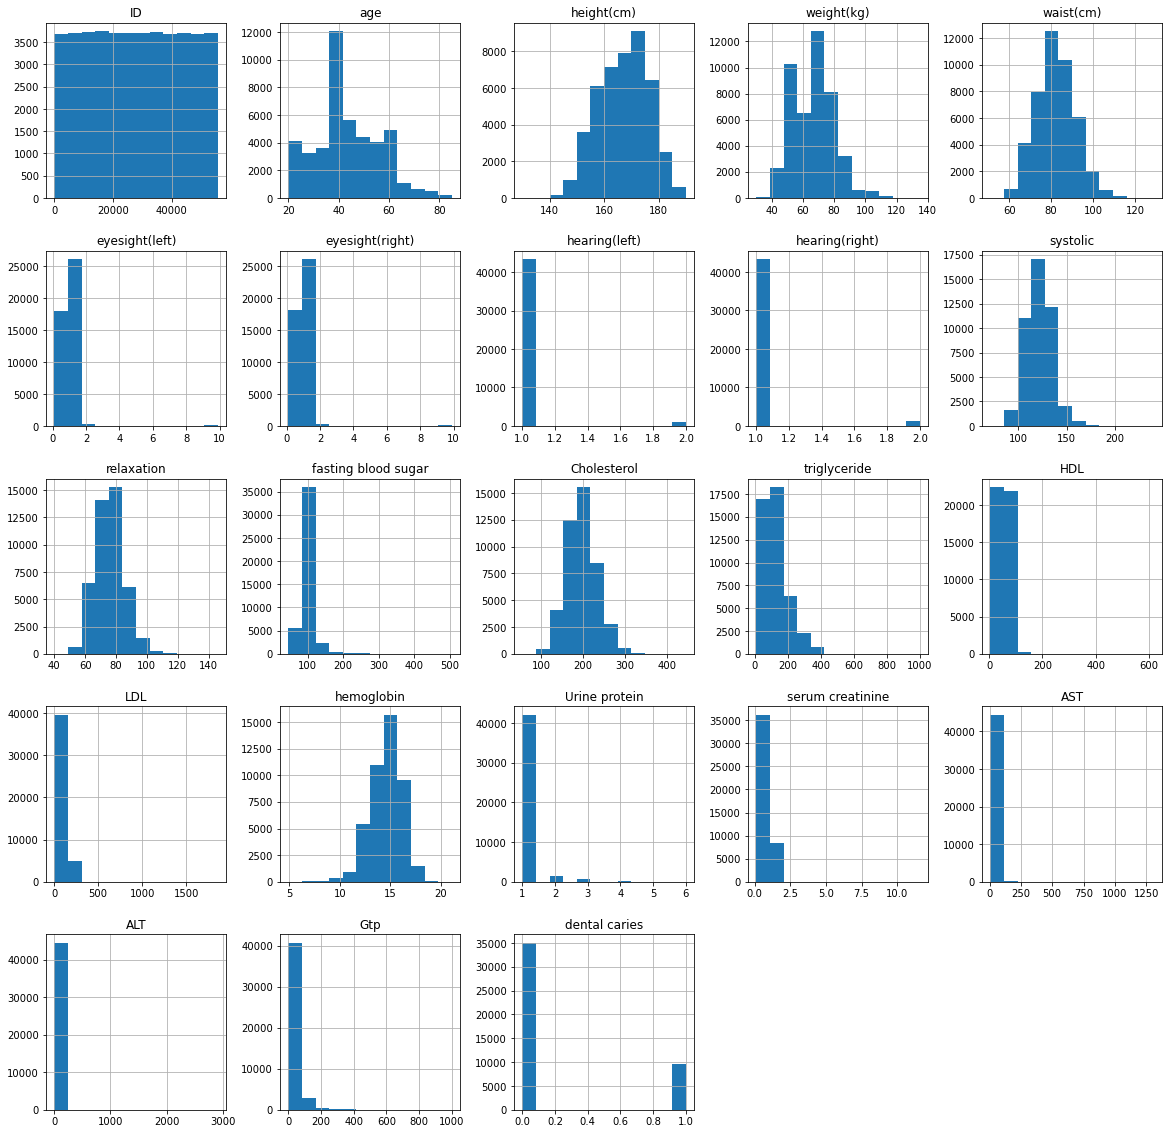

In [7]:
# x_train 시각화
x_train.hist(figsize = (20, 20), bins = 12, legend=False)

### 랜덤포레스트(Random Forest) 적용

In [12]:
# 랜덤포레스트 객체 생성
from sklearn.metrics import accuracy_score, precision_score , recall_score
rf_clf_100 = RandomForestClassifier(random_state=0, n_estimators=50)
rf_clf_100.fit(x_train_org, y_train_org)
pred = rf_clf_100.predict(x_test_org)
accuracy = accuracy_score(y_test_org, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

C:\Users\Yeon\AppData\Local\Temp\ipykernel_14528\3046876530.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_100.fit(x_train_org, y_train_org)


랜덤 포레스트 정확도: 0.9998


In [13]:
# 정확도 / 정밀도 / 재현율
print("정확도 : ", accuracy_score(y_test_org, pred))
print("정밀도 : ", precision_score(y_test_org, pred))
print("재현율 : ", recall_score(y_test_org, pred))

정확도 :  0.9998204506688213
정밀도 :  1.0
재현율 :  0.9995125517913722


- 랜덤 포레스트 모델로 정확도, 정밀도, 재현율을 출력했을 때 과적합 발생

### GridSearchCV로 교차검증 및 하이퍼 파라미터 튜닝

In [22]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[50],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(x_train_org, y_train_org)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

C:\Users\Yeon\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 50}
최고 예측 정확도: 0.7554


In [23]:
# 튜닝된 하이퍼파라미터로 재학습/예측/평가 - 분류기 수를 확장
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=12, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf.fit(x_train_org,y_train_org)
pred= rf_clf.predict(x_test_org)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test_org, pred)))

C:\Users\Yeon\AppData\Local\Temp\ipykernel_14528\342985449.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train_org,y_train_org)


예측 정확도: 0.8310


In [24]:
rf_clf.score(x_train_org, y_train_org)

0.8284066168383722

In [25]:
# 정확도 / 정밀도 / 재현율
print("정확도 : ", accuracy_score(y_test_org, pred))
print("정밀도 : ", precision_score(y_test_org, pred))
print("재현율 : ", recall_score(y_test_org, pred))

정확도 :  0.8310440793608044
정밀도 :  0.7492704826038159
재현율 :  0.8135510601998538


과적합을 해결하기 위해 파라미터 값 조정
- n_estimators: 50
- max_depth: 12
- min_samples_leaf: 8
- min_samples_split: 8

### 개별 feature들의 중요도 시각화

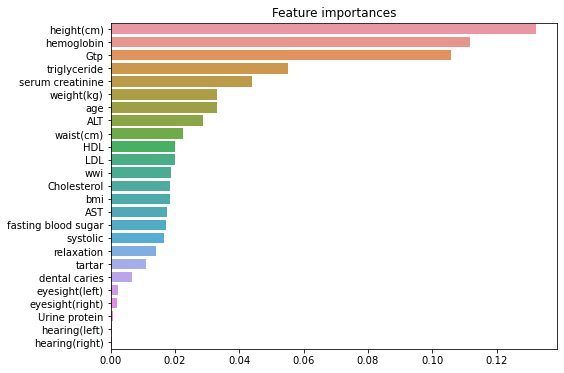

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_import = rf_clf.feature_importances_
ftr_import_se = pd.Series(ftr_import, index=x_train_org.columns)
ftr_import = ftr_import_se.sort_values(ascending=False)#[:20] # 중요도가 높은 20개의 피처만 추출
ftr_import = ftr_import[1:]

plt.figure(figsize=(8,6))
plt.title('Feature importances')
# x축은 중요도 값, y축은 ftr_top20 시리즈의 index
sns.barplot(x=ftr_import,y=ftr_import.index) # 가로막대 그래프
plt.show()

### ROC AUC Curve

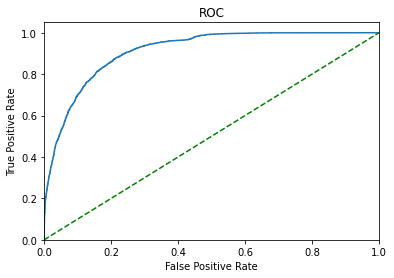

In [19]:
rf_roc_auc = roc_auc_score(y_test_org, rf_clf.predict(x_test_org))
fpr, tpr, thresholds = roc_curve(y_test_org, rf_clf.predict_proba(x_test_org)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

### Confusion Matrix

C:\Users\Yeon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


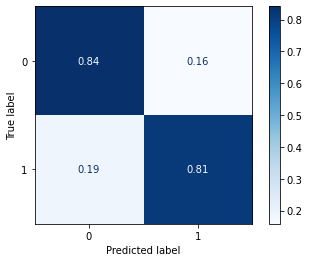

In [21]:
plot_confusion_matrix(rf_clf, x_test_org, y_test_org, cmap = plt.cm.Blues, normalize = "true");